## PROJECT DESCRIPTION:

Illinois is famous for being one of the very few states in the country with negative population growth. The objective of your final project is to:

•Identify the key reasons for the declining population by extracting meaningful insights from unstructured text
•Provide actionable recommendations on what can be done to reverse this trend

The news articles are related to either Chicago and / or Illinois.


In [370]:
import pandas as pd

import string

import re

import matplotlib.pyplot as plt

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud


## Loading, Cleaning, Prepping

In [2]:
news = pd.read_pickle("/Users/chrisolen/Documents/uchicago_courses/natural_language_processing/final_project/news_chicago_il.pkl")

In [3]:
news.shape

(28604, 4)

In [4]:
news.columns

Index(['crawled', 'language', 'text', 'title'], dtype='object')

In [5]:
news = news['text']

In [36]:
# Set of stop words:

stop = set(stopwords.words('english'))

# Adding contractions with different apostrophe encoding:

stop.add('it’s')
stop.add('don’t')
stop.add('they’re')
stop.add('didn’t')
stop.add('can’t')
stop.add('doesn’t')
stop.add('couldn’t')
stop.add('hasn’t')
stop.add('hadn’t')
stop.add('haven’t')
stop.add('isn’t')
stop.add('should’ve')
stop.add('shouldn’t')
stop.add('that’ll')
stop.add('wasn’t')
stop.add('weren’t')
stop.add('won’t')
stop.add('wouldn’t')
stop.add('you’re')
stop.add('you’d')
stop.add('you’ve')

In [7]:
# Set of punctuation:

exclude = set(string.punctuation)
exclude.remove('-')
exclude.remove('_')
exclude.add('°')
exclude.add('©')
exclude.add('“')
exclude.add('”')
exclude.add('–')
exclude.add('®')
exclude.add('•')
exclude.add('…')

In [8]:
# Cleaning docs of stop words and function; applying .lower():

def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_stop_free = ''.join(ch for ch in stop_free if ch not in exclude)
    dash_cleaned = punc_stop_free.replace("-"," ").replace("_"," ")
    quote_cleaned = dash_cleaned.replace('\"',"")
    double_space_cleaned = quote_cleaned.replace("  "," ")
    zero_width_space_cleaned = double_space_cleaned.replace("\u200b","")
    single_removed = " ".join([word for word in zero_width_space_cleaned.split() if len(word) > 1])
    time_date_removed = single_removed.replace("pm","").replace("am","").replace("pdt","").replace("edt","").replace("cdt","").replace("utc","")
    return time_date_removed

news_clean = [clean(doc) for doc in news]

In [9]:
# Removing urls from docs:

def remove_urls(doc):
    url_list1 = re.findall('http\w+',doc)
    for i in range(len(url_list1)):
        doc = doc.replace(url_list1[i],"")
    url_list2 = re.findall('http[\S]+',doc)
    for j in range(len(url_list2)):    
        doc = doc.replace(url_list2[j],"")
    url_list3 = re.findall('www\w+',doc)
    for k in range(len(url_list3)):    
        doc = doc.replace(url_list3[k],"")
    url_list4 = re.findall("pictwitter\w+",doc)
    for l in range(len(url_list4)):    
        doc = doc.replace(url_list4[l],"")
    return doc
    
news_clean = [remove_urls(doc) for doc in news_clean]

In [11]:
# Removing codes, screen names, etc. with length greater than 5 (i.e. shouldn't remove years, but should remove '455pm', '1st', '24th'):

letters_nums = []
for i in range(len(news_clean)):
    letters_nums.append(re.findall("([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)",news_clean[i]))
letters_nums = [item for sublist in letters_nums for item in sublist]

#To reduce the number of letter-number segments removed from the corpus:

letters_nums = set([letters_nums[i] for i in range(len(letters_nums)) if len(letters_nums[i]) > 2])

def remove_codes(doc):
    code_free = " ".join([i for i in doc.split() if i not in letters_nums])
    return code_free

news_clean = [remove_codes(doc) for doc in news_clean]

In [12]:
# Removing large numbers (over 4) to maintain years:

large_nums = []
for i in range(len(news_clean)):
    large_nums.append(re.findall("\d\d\d\d\d+",news_clean[i]))
large_nums = set([item for sublist in large_nums for item in sublist])

def remove_numbers(doc):
    num_free = " ".join([i for i in doc.split() if i not in large_nums])
    return num_free

news_clean = [remove_numbers(doc) for doc in news_clean]

In [14]:
# Carrying out pos tagging and lemmatization:

docs_words = [doc.split() for doc in news_clean]
postags = [nltk.pos_tag(doc) for doc in docs_words]

def lets_lemmatize(this_massive_file):
    lemmatized = []
    wnl = WordNetLemmatizer()
    nouns = [(i, wnl.lemmatize(this_massive_file[i][0], pos = 'n')) for i in range(len(this_massive_file)) if this_massive_file[i][1] in ['NN','NNS','NNP','NNPS']]
    lemmatized.extend(nouns)
    verbs = [(i, wnl.lemmatize(this_massive_file[i][0], pos = 'v')) for i in range(len(this_massive_file)) if this_massive_file[i][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']]
    lemmatized.extend(verbs)
    everything_else = [(i,this_massive_file[i][0]) for i in range(len(this_massive_file)) if this_massive_file[i][1] not in ['VB','VBD','VBG','VBN','VBP','VBZ','NN','NNS','NNP','NNPS']]
    lemmatized.extend(everything_else)
    lemmatized = sorted(lemmatized, key=lambda x: x[0])
    return lemmatized

news_clean = [lets_lemmatize(doc) for doc in postags]

news_final = [" ".join([word[1] for word in news_clean[i]]) for i in range(len(news_clean))]

In [16]:
# Take a gander at cleaned up file:

news_final

['second pick draft round no 126 overall bear select georgia wr riley ridley little brother atlanta falcon 2018 first round all rookie wr calvin ridley foot 199 pound catch te high 44 ball 570 yard nine touchdown true junior last year first',
 'article chicago tribune contact reporter ted slowik toss 1899 silver dollar decide tie tuesday election trustee sauk village gary bell call tail seat village board coin land tail side up bell beth zupon receive 288 vote ballot count follow april election cook county clerk’s office say bell 54 deputy director sauk village homeland security emergency management agency village board honor former firefighter 2014 upon retirement 30 year sauk village fire department first time bell run public office say ran two people run first give them bell say they’re friend vote staggeringly low voter turnout erican democracy',
 'fill detail click icon log in email require address never make public ne require comment use wordpresscom account log change comment us

## Let's try some unsupervised learning:

### Latent Dirichlet Allocation
Need to first convert to document term matrix

In [15]:
# Splitting cleaned file into a list of lists of words:

docs_split = [doc.split() for doc in news_final]     

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(docs_split)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs_split]


In [17]:
# 4 custers, chosen arbitrarily, to be compared:

"""
#LDA: 15 Topics
lda15 = LdaMulticore(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50) 

#LDA: 10 Topics
lda10 = LdaMulticore(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50) 

#LDA: 7 Topics
lda7 = LdaMulticore(doc_term_matrix, num_topics=7, id2word = dictionary, passes=50) 

#LDA: 5 Topics
lda5 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 


In [20]:
"""
lda15_display = pyLDAvis.gensim.prepare(lda15, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda15_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [22]:
"""
lda10_display = pyLDAvis.gensim.prepare(lda10, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda10_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
"""
lda7_display = pyLDAvis.gensim.prepare(lda7, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda7_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [24]:
"""
lda5_display = pyLDAvis.gensim.prepare(lda5, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda5_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### N_Topics = 5 seems to return the most coherent results,  where:

Topic 5: Mostly crime-related

Topic 4: Mostly government, public sector-related

Topic 3: Mostly industry, jobs-related

Topic 2: Mostly stock market, financial sector-related

Topic 1: Seems to be a bit of a catch-all

## Latent Semantic Analysis
Another unsupervised approach to judging the appropriate number of topics in the corpus

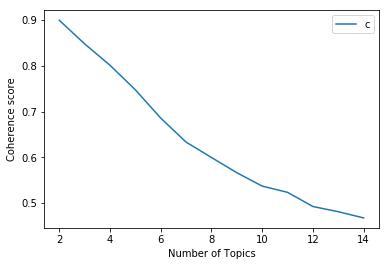

In [28]:
#Let's get an idea of topic coherence per number of chosen topics:

def prepare_corpus(docs_split):

    dictionary = corpora.Dictionary(docs_split)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs_split]
    return dictionary,doc_term_matrix

def compute_coherence_values(dictionary, doc_term_matrix, docs_split, end, start=2, step=3):

    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step)
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs_split, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

def plot_graph(docs_split,start, end, step):
    
    dictionary,doc_term_matrix=prepare_corpus(docs_split)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,docs_split,
                                                            end, start, step)
    x = range(start, end, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,end,step=2,15,1

plot_graph(docs_split,start,end,step)

Topic coherence decreases monotonically with number of topics

In [32]:
#Let's run an LSI model on 5 topics:

lsamodel = LsiModel(doc_term_matrix, num_topics=5, id2word = dictionary)
lsamodel.print_topics(num_topics=5, num_words=15)

[(0,
  '0.661*"day" + 0.218*"date" + 0.188*"deth" + 0.183*"number" + 0.181*"chicago" + 0.166*"birthdate" + 0.152*"uf" + 0.137*"tu" + 0.120*"march" + 0.118*"bush" + 0.109*"2019" + 0.097*"april" + 0.093*"trump" + 0.093*"20" + 0.088*"post"'),
 (1,
  '-0.273*"illinois" + 0.258*"day" + -0.216*"say" + -0.205*"work" + -0.189*"year" + -0.180*"chicago" + -0.178*"get" + -0.178*"share" + -0.144*"car" + -0.143*"company" + -0.132*"tool" + -0.113*"go" + -0.111*"would" + -0.111*"stock" + -0.111*"one"'),
 (2,
  '0.331*"share" + 0.312*"illinois" + 0.282*"tool" + 0.229*"stock" + 0.218*"work" + -0.208*"chicago" + -0.194*"say" + 0.181*"rating" + 0.179*"quarter" + -0.152*"car" + -0.140*"get" + 0.119*"sell" + 0.115*"inc" + -0.106*"go" + 0.100*"product"'),
 (3,
  '0.530*"car" + -0.459*"chicago" + 0.279*"get" + -0.171*"say" + 0.138*"much" + 0.134*"company" + 0.131*"would" + 0.118*"i’m" + 0.117*"pay" + 0.117*"cost" + 0.110*"know" + 0.104*"health" + -0.104*"city" + 0.095*"need" + -0.091*"may"'),
 (4,
  '0.612*"

LSA results aren't as coherent as were the LDA results, so I think I'll just stick with LDA

Let's drill down into the original five topics a bit more, keeping only the documents that are associated with a topic with some certainty:

In [92]:
# Get document topics with certainty of over 30 percent:

doc_topics = [lda5.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in docs_split]


In [145]:
# Take the top topics only, discard topics below 30 percent:

top_topic = {}

for i in range(len(doc_topics)):
    
    if len(doc_topics[i]) > 1:
        listy = [k[1] for k in doc_topics[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics[i][indexy]
    
    elif len(doc_topics[i]) == 1:
        top_topic[i] = doc_topics[i][0]
            
    else:
        pass
    

In [172]:
# Take a gander:

top_topic

{0: (1, 0.78374785),
 1: (3, 0.42785972),
 2: (3, 0.97926),
 3: (3, 0.48089412),
 4: (0, 0.4582882),
 5: (0, 0.45769465),
 6: (0, 0.6054952),
 7: (1, 0.48572057),
 8: (2, 0.50188977),
 9: (1, 0.41035816),
 11: (1, 0.9986491),
 12: (1, 0.6787474),
 13: (3, 0.5901926),
 14: (0, 0.68246335),
 15: (0, 0.568815),
 16: (3, 0.40938345),
 17: (0, 0.61364776),
 18: (0, 0.7281426),
 19: (2, 0.65588045),
 20: (0, 0.99626285),
 21: (0, 0.9622132),
 22: (2, 0.9771921),
 23: (3, 0.52504945),
 24: (1, 0.99865395),
 25: (2, 0.5478024),
 26: (0, 0.6438977),
 27: (0, 0.7072333),
 28: (3, 0.5385252),
 29: (4, 0.87044215),
 30: (1, 0.8245044),
 31: (1, 0.6653504),
 32: (1, 0.43942958),
 33: (4, 0.83827245),
 34: (0, 0.7545291),
 35: (0, 0.8746789),
 36: (0, 0.93188953),
 37: (4, 0.685975),
 39: (4, 0.69255954),
 40: (0, 0.3965303),
 41: (4, 0.52943003),
 42: (3, 0.42836624),
 43: (0, 0.398932),
 44: (3, 0.69533914),
 45: (0, 0.7839784),
 46: (0, 0.4894927),
 47: (4, 0.750171),
 49: (3, 0.5951279),
 50: (1

In [157]:
# Getting keys/indexes specific to each topic:

topic_1 = {}
topic_2 = {}
topic_3 = {}
topic_4 = {}
topic_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_4[key] = top_topic[key]
    else:
        topic_5[key] = top_topic[key]

topic_1_keys = list(topic_1.keys())
topic_2_keys = list(topic_2.keys())
topic_3_keys = list(topic_3.keys())
topic_4_keys = list(topic_4.keys())
topic_5_keys = list(topic_5.keys())


In [173]:
# Take a gander:

topic_1

{4: (0, 0.4582882),
 5: (0, 0.45769465),
 6: (0, 0.6054952),
 14: (0, 0.68246335),
 15: (0, 0.568815),
 17: (0, 0.61364776),
 18: (0, 0.7281426),
 20: (0, 0.99626285),
 21: (0, 0.9622132),
 26: (0, 0.6438977),
 27: (0, 0.7072333),
 34: (0, 0.7545291),
 35: (0, 0.8746789),
 36: (0, 0.93188953),
 40: (0, 0.3965303),
 43: (0, 0.398932),
 45: (0, 0.7839784),
 46: (0, 0.4894927),
 53: (0, 0.37624213),
 63: (0, 0.8490436),
 68: (0, 0.84079266),
 69: (0, 0.7205292),
 80: (0, 0.7649934),
 83: (0, 0.6429086),
 89: (0, 0.56942785),
 91: (0, 0.5385639),
 93: (0, 0.7065625),
 94: (0, 0.4417285),
 102: (0, 0.9382683),
 103: (0, 0.8937112),
 105: (0, 0.60351914),
 113: (0, 0.9589803),
 116: (0, 0.9259779),
 117: (0, 0.61027473),
 120: (0, 0.7612198),
 126: (0, 0.88472235),
 129: (0, 0.8767368),
 131: (0, 0.39435536),
 133: (0, 0.89710265),
 134: (0, 0.49532965),
 136: (0, 0.9821562),
 137: (0, 0.5155124),
 139: (0, 0.51327485),
 143: (0, 0.9382764),
 154: (0, 0.88415754),
 158: (0, 0.42225057),
 159

In [174]:
# Topic 5-Specific LDA:

# Pulling out only articles related to topic 5:

topic_5_docs = [docs_split[i] for i in topic_5_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_5_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_5_docs]

# LDA:

lda5_topic5 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 

In [175]:
lda5_topic5_display = pyLDAvis.gensim.prepare(lda5_topic5, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda5_topic5_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 5 Sub Topics:

1. Possibly related to Jussie Smollett case

2. Violent crime-related; some named entities listed

3. Daoud terrorism case 

4. Jaylon McKenzie case

5. More violent crime-related

In [410]:
# Pulling out only articles related to topic 5:

topic_5_docs = [docs_split[i] for i in topic_5_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_5_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_5_docs]

# Get document topics with certainty of over 30 percent:

doc_topics_5 = dict(zip(topic_5_keys,[lda5_topic5.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in topic_5_docs]))

# Take the top topic only, discard topics below 30 percent:

top_topic = {}
for i in doc_topics_5:
    if len(doc_topics_5[i]) > 1:
        listy = [k[1] for k in doc_topics_5[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics_5[i][indexy]
    
    elif len(doc_topics_5[i]) == 1:
        top_topic[i] = doc_topics_5[i][0]
            
    else:
        pass
    
# Getting keys/indexes specific to each topic:

topic_5_1 = {}
topic_5_2 = {}
topic_5_3 = {}
topic_5_4 = {}
topic_5_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_5_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_5_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_5_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_5_4[key] = top_topic[key]
    else:
        topic_5_5[key] = top_topic[key]

topic_5_1_keys = list(topic_5_1.keys())
topic_5_2_keys = list(topic_5_2.keys())
topic_5_3_keys = list(topic_5_3.keys())
topic_5_4_keys = list(topic_5_4.keys())
topic_5_5_keys = list(topic_5_5.keys())

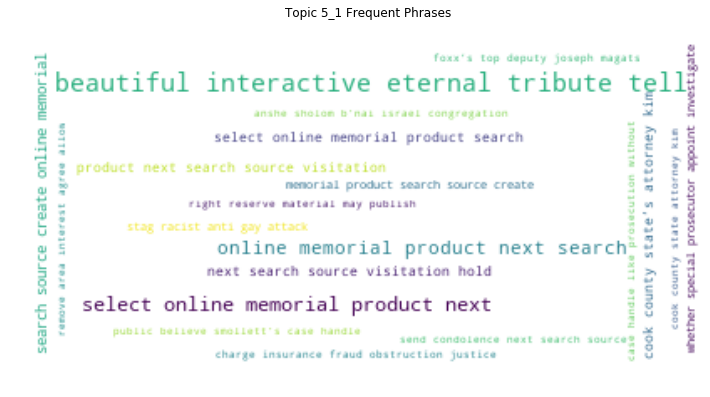


Representing 3 percent of the corpus


In [450]:
# Topic 5_1

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_5_1_text = [news_final[i] for i in topic_5_1_keys]
topic_5_1_text = " ".join([doc for doc in topic_5_1_text])
topic_5_1_text = topic_5_1_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_5_1_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_5_1_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_5_1_df.iterrows():
    if i[0] != 0:
        if fdist_5_1_df.iloc[i[0],1] == fdist_5_1_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_5_1_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_5_1_df = fdist_5_1_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_5_1_df['Phrase'] = fdist_5_1_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_5_1_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 5_1 Frequent Phrases\n")
plt.show()

topic_5_1_text = [news_final[i] for i in topic_5_1_keys]
percent = len(topic_5_1_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)

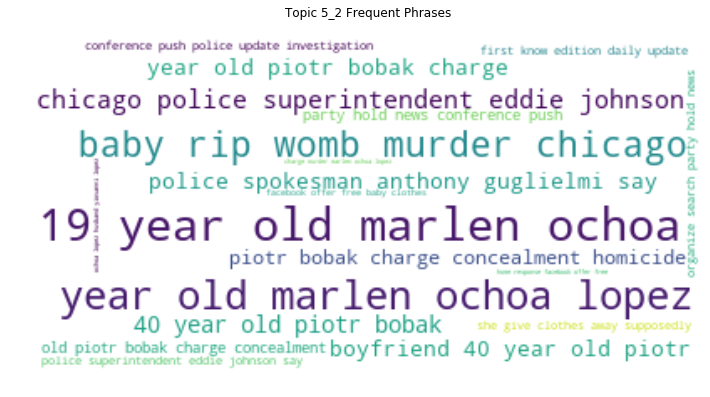


Representing 3 percent of the corpus


In [451]:
# Topic 5_2

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_5_2_text = [news_final[i] for i in topic_5_2_keys]
topic_5_2_text = " ".join([doc for doc in topic_5_2_text])
topic_5_2_text = topic_5_2_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_5_2_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_5_2_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_5_2_df.iterrows():
    if i[0] != 0:
        if fdist_5_2_df.iloc[i[0],1] == fdist_5_2_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_5_2_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_5_2_df = fdist_5_2_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_5_2_df['Phrase'] = fdist_5_2_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_5_2_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 5_2 Frequent Phrases\n")
plt.show()

topic_5_2_text = [news_final[i] for i in topic_5_2_keys]
percent = len(topic_5_2_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


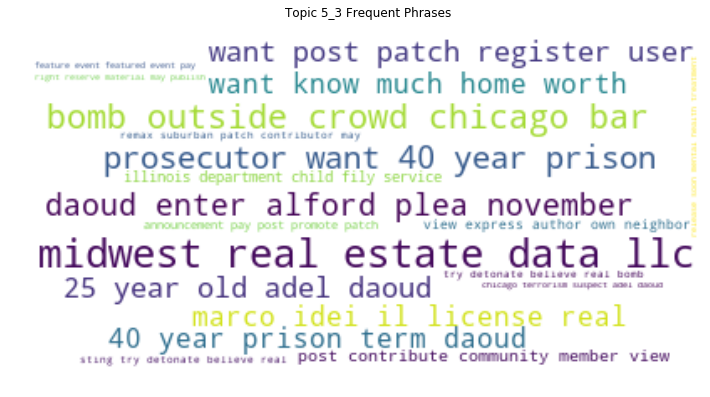


Representing 2 percent of the corpus


In [453]:
# Topic 5_3

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_5_3_text = [news_final[i] for i in topic_5_3_keys]
topic_5_3_text = " ".join([doc for doc in topic_5_3_text])
topic_5_3_text = topic_5_3_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_5_3_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_5_3_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_5_3_df.iterrows():
    if i[0] != 0:
        if fdist_5_3_df.iloc[i[0],1] == fdist_5_3_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_5_3_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_5_3_df = fdist_5_3_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_5_3_df['Phrase'] = fdist_5_3_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_5_3_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 5_3 Frequent Phrases\n")
plt.show()

topic_5_3_text = [news_final[i] for i in topic_5_3_keys]
percent = len(topic_5_3_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)



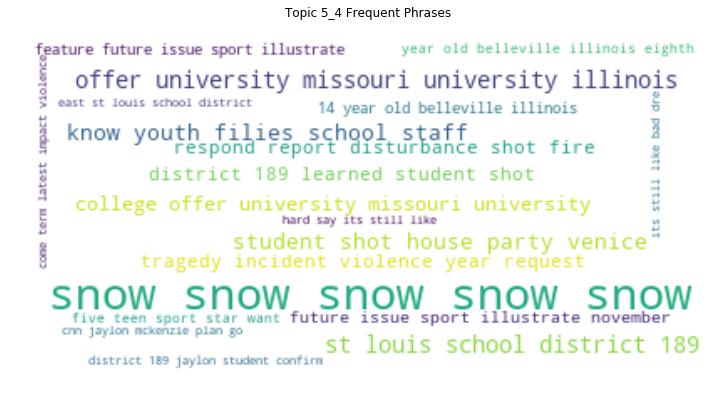


Representing 2 percent of the corpus


In [454]:
# Topic 5_4

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_5_4_text = [news_final[i] for i in topic_5_4_keys]
topic_5_4_text = " ".join([doc for doc in topic_5_4_text])
topic_5_4_text = topic_5_4_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_5_4_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_5_4_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_5_4_df.iterrows():
    if i[0] != 0:
        if fdist_5_4_df.iloc[i[0],1] == fdist_5_4_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_5_4_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_5_4_df = fdist_5_4_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_5_4_df['Phrase'] = fdist_5_4_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_5_4_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 5_4 Frequent Phrases\n")
plt.show()

topic_5_4_text = [news_final[i] for i in topic_5_4_keys]
percent = len(topic_5_4_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


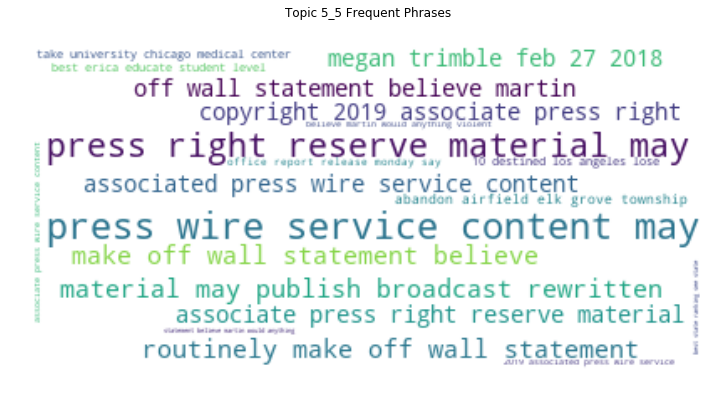


Representing 4 percent of the corpus


In [455]:
# Topic 5_5

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_5_5_text = [news_final[i] for i in topic_5_5_keys]
topic_5_5_text = " ".join([doc for doc in topic_5_5_text])
topic_5_5_text = topic_5_5_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_5_5_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_5_5_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_5_5_df.iterrows():
    if i[0] != 0:
        if fdist_5_5_df.iloc[i[0],1] == fdist_5_5_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_5_5_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_5_5_df = fdist_5_5_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_5_5_df['Phrase'] = fdist_5_5_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_5_5_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 5_5 Frequent Phrases\n")
plt.show()

topic_5_5_text = [news_final[i] for i in topic_5_5_keys]
percent = len(topic_5_5_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [176]:
# Topic 4-Specific LDA:

#Pulling out only articles related to topic 4:

topic_4_docs = [docs_split[i] for i in topic_4_keys]

#Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_4_docs)

#Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_4_docs]

#LDA:

lda4_topic4 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 

In [177]:
lda4_topic4_display = pyLDAvis.gensim.prepare(lda4_topic4, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda4_topic4_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 4 Sub Topics

1. Marijuana Legalization

2. Something related to cars

3. Consumer credit and debt

4. Real estate, proprty, legal concerns

5. Education policies, pensions, taxes

In [418]:
# Pulling out only articles related to topic 4:

topic_4_docs = [docs_split[i] for i in topic_4_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_4_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_4_docs]

# Get document topics with certainty of over 30 percent:

doc_topics_4 = dict(zip(topic_4_keys,[lda4_topic4.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in topic_4_docs]))

# Take the top topic only, discard topics below 30 percent:

top_topic = {}
for i in doc_topics_4:
    if len(doc_topics_4[i]) > 1:
        listy = [k[1] for k in doc_topics_4[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics_4[i][indexy]
    
    elif len(doc_topics_4[i]) == 1:
        top_topic[i] = doc_topics_4[i][0]
            
    else:
        pass
    
# Getting keys/indexes specific to each topic:

topic_4_1 = {}
topic_4_2 = {}
topic_4_3 = {}
topic_4_4 = {}
topic_4_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_4_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_4_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_4_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_4_4[key] = top_topic[key]
    else:
        topic_4_5[key] = top_topic[key]

topic_4_1_keys = list(topic_4_1.keys())
topic_4_2_keys = list(topic_4_2.keys())
topic_4_3_keys = list(topic_4_3.keys())
topic_4_4_keys = list(topic_4_4.keys())
topic_4_5_keys = list(topic_4_5.keys())

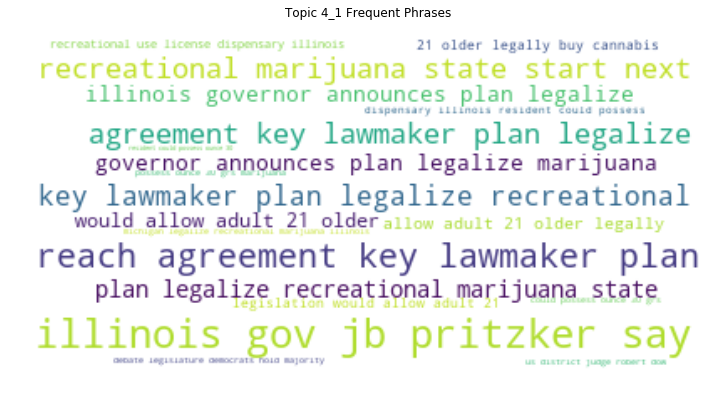


Representing 4 percent of the corpus


In [456]:
# Topic 4_1

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_4_1_text = [news_final[i] for i in topic_4_1_keys]
topic_4_1_text = " ".join([doc for doc in topic_4_1_text])
topic_4_1_text = topic_4_1_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_4_1_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_4_1_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_4_1_df.iterrows():
    if i[0] != 0:
        if fdist_4_1_df.iloc[i[0],1] == fdist_4_1_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_4_1_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_4_1_df = fdist_4_1_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_4_1_df['Phrase'] = fdist_4_1_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_4_1_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 4_1 Frequent Phrases\n")
plt.show()

topic_4_1_text = [news_final[i] for i in topic_4_1_keys]
percent = len(topic_4_1_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)



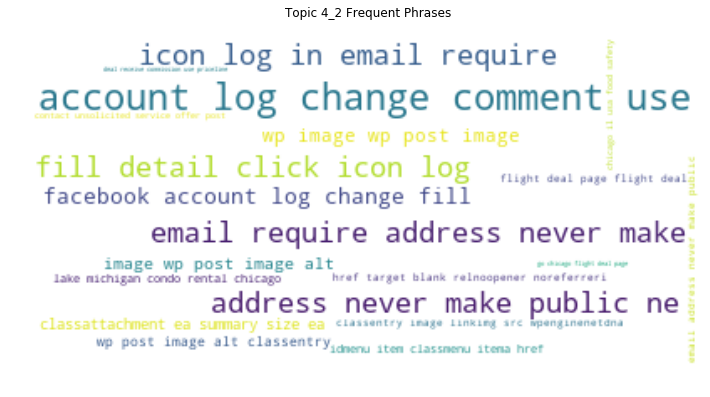


Representing 3 percent of the corpus


In [457]:
# Topic 4_2

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_4_2_text = [news_final[i] for i in topic_4_2_keys]
topic_4_2_text = " ".join([doc for doc in topic_4_2_text])
topic_4_2_text = topic_4_2_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_4_2_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_4_2_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_4_2_df.iterrows():
    if i[0] != 0:
        if fdist_4_2_df.iloc[i[0],1] == fdist_4_2_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_4_2_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_4_2_df = fdist_4_2_df.iloc[0:20] 

# Change the ngram from tuple to string:
def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_4_2_df['Phrase'] = fdist_4_2_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:
d = {}
for a, x in fdist_4_2_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 4_2 Frequent Phrases\n")
plt.show()

topic_4_2_text = [news_final[i] for i in topic_4_2_keys]
percent = len(topic_4_2_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


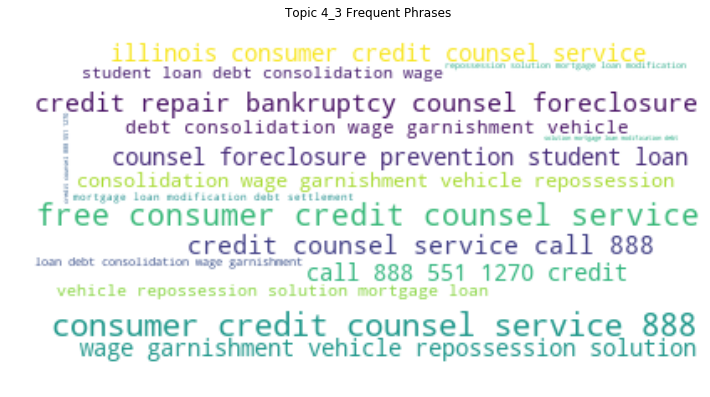


Representing 1 percent of the corpus


In [458]:
# Topic 4_3

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_4_3_text = [news_final[i] for i in topic_4_3_keys]
topic_4_3_text = " ".join([doc for doc in topic_4_3_text])
topic_4_3_text = topic_4_3_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_4_3_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_4_3_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_4_3_df.iterrows():
    if i[0] != 0:
        if fdist_4_3_df.iloc[i[0],1] == fdist_4_3_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_4_3_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_4_3_df = fdist_4_3_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_4_3_df['Phrase'] = fdist_4_3_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_4_3_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 4_3 Frequent Phrases\n")
plt.show()

topic_4_3_text = [news_final[i] for i in topic_4_3_keys]
percent = len(topic_4_3_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


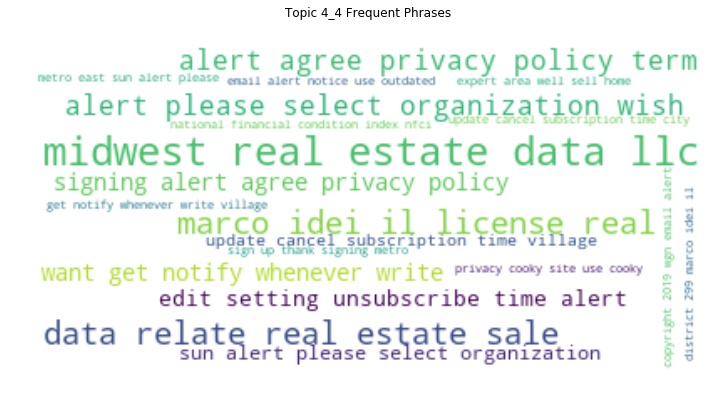


Representing 3 percent of the corpus


In [459]:
# Topic 4_4

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_4_4_text = [news_final[i] for i in topic_4_4_keys]
topic_4_4_text = " ".join([doc for doc in topic_4_4_text])
topic_4_4_text = topic_4_4_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_4_4_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_4_4_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_4_4_df.iterrows():
    if i[0] != 0:
        if fdist_4_4_df.iloc[i[0],1] == fdist_4_4_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_4_4_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_4_4_df = fdist_4_4_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_4_4_df['Phrase'] = fdist_4_4_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_4_4_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 4_4 Frequent Phrases\n")
plt.show()

topic_4_4_text = [news_final[i] for i in topic_4_4_keys]
percent = len(topic_4_4_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


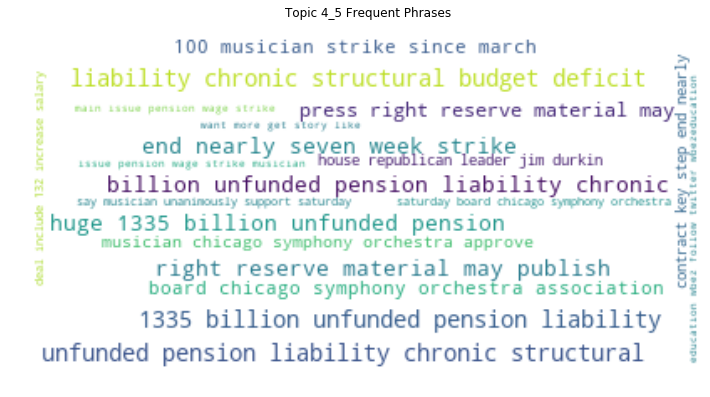


Representing 5 percent of the corpus


In [460]:
# Topic 4_5

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_4_5_text = [news_final[i] for i in topic_4_5_keys]
topic_4_5_text = " ".join([doc for doc in topic_4_5_text])
topic_4_5_text = topic_4_5_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_4_5_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_4_5_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_4_5_df.iterrows():
    if i[0] != 0:
        if fdist_4_5_df.iloc[i[0],1] == fdist_4_5_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_4_5_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_4_5_df = fdist_4_5_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_4_5_df['Phrase'] = fdist_4_5_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_4_5_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 4_5 Frequent Phrases\n")
plt.show()

topic_4_5_text = [news_final[i] for i in topic_4_5_keys]
percent = len(topic_4_5_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [178]:
# Topic 3-Specific LDA:

# Pulling out only articles related to topic 3:

topic_3_docs = [docs_split[i] for i in topic_3_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_3_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_3_docs]

# LDA:

lda3_topic3 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 

In [179]:
lda3_topic3_display = pyLDAvis.gensim.prepare(lda3_topic3, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda3_topic3_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 3 Sub Topics:

1. University, community college, research

2. Software, services, business systems

3. Discussions of technology, growth, markets

4. Health care discussions

5. Seems to be about job openings, position descriptions

In [424]:
# Pulling out only articles related to topic 3:

topic_3_docs = [docs_split[i] for i in topic_3_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_3_docs)

# Converting list of documents into document term matrix using dictionary prepared above:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_3_docs]

# Get document topics with certainty of over 30 percent:

doc_topics_3 = dict(zip(topic_3_keys,[lda3_topic3.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in topic_3_docs]))

# Take the top topic only, discard topics below 30 percent:

top_topic = {}
for i in doc_topics_3:
    if len(doc_topics_3[i]) > 1:
        listy = [k[1] for k in doc_topics_3[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics_3[i][indexy]
    
    elif len(doc_topics_3[i]) == 1:
        top_topic[i] = doc_topics_3[i][0]
            
    else:
        pass
    
# Getting keys/indexes specific to each topic:

topic_3_1 = {}
topic_3_2 = {}
topic_3_3 = {}
topic_3_4 = {}
topic_3_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_3_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_3_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_3_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_3_4[key] = top_topic[key]
    else:
        topic_3_5[key] = top_topic[key]

topic_3_1_keys = list(topic_3_1.keys())
topic_3_2_keys = list(topic_3_2.keys())
topic_3_3_keys = list(topic_3_3.keys())
topic_3_4_keys = list(topic_3_4.keys())
topic_3_5_keys = list(topic_3_5.keys())

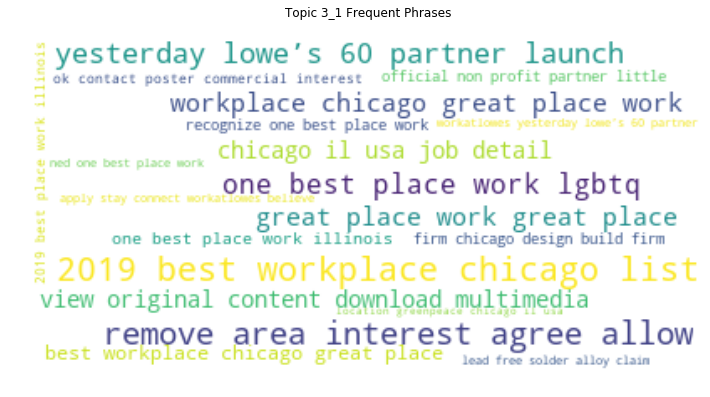


Representing 3 percent of the corpus


In [461]:
# Topic 3_1

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_3_1_text = [news_final[i] for i in topic_3_1_keys]
topic_3_1_text = " ".join([doc for doc in topic_3_1_text])
topic_3_1_text = topic_3_1_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_3_1_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_3_1_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_3_1_df.iterrows():
    if i[0] != 0:
        if fdist_3_1_df.iloc[i[0],1] == fdist_3_1_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_3_1_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_3_1_df = fdist_3_1_df.iloc[0:20] 

#Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_3_1_df['Phrase'] = fdist_3_1_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_3_1_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 3_1 Frequent Phrases\n")
plt.show()

topic_3_1_text = [news_final[i] for i in topic_3_1_keys]
percent = len(topic_3_1_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


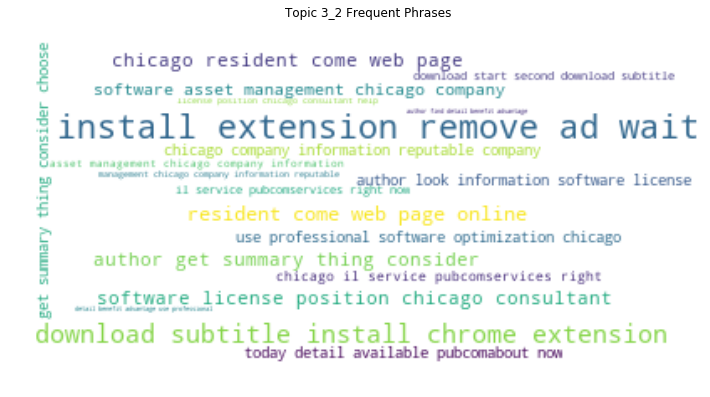


Representing 2 percent of the corpus


In [462]:
# Topic 3_2

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_3_2_text = [news_final[i] for i in topic_3_2_keys]
topic_3_2_text = " ".join([doc for doc in topic_3_2_text])
topic_3_2_text = topic_3_2_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_3_2_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_3_2_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_3_2_df.iterrows():
    if i[0] != 0:
        if fdist_3_2_df.iloc[i[0],1] == fdist_3_2_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_3_2_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_3_2_df = fdist_3_2_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_3_2_df['Phrase'] = fdist_3_2_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_3_2_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 3_2 Frequent Phrases\n")
plt.show()

topic_3_2_text = [news_final[i] for i in topic_3_2_keys]
percent = len(topic_3_2_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


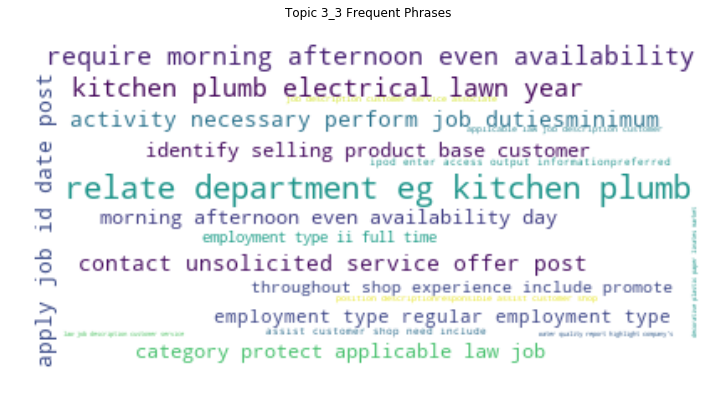


Representing 2 percent of the corpus


In [463]:
# Topic 3_3

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:
topic_3_3_text = [news_final[i] for i in topic_3_3_keys]
topic_3_3_text = " ".join([doc for doc in topic_3_3_text])
topic_3_3_text = topic_3_3_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_3_3_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_3_3_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):
indexes_to_remove = []
for i in fdist_3_3_df.iterrows():
    if i[0] != 0:
        if fdist_3_3_df.iloc[i[0],1] == fdist_3_3_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_3_3_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_3_3_df = fdist_3_3_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_3_3_df['Phrase'] = fdist_3_3_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_3_3_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 3_3 Frequent Phrases\n")
plt.show()

topic_3_3_text = [news_final[i] for i in topic_3_3_keys]
percent = len(topic_3_3_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


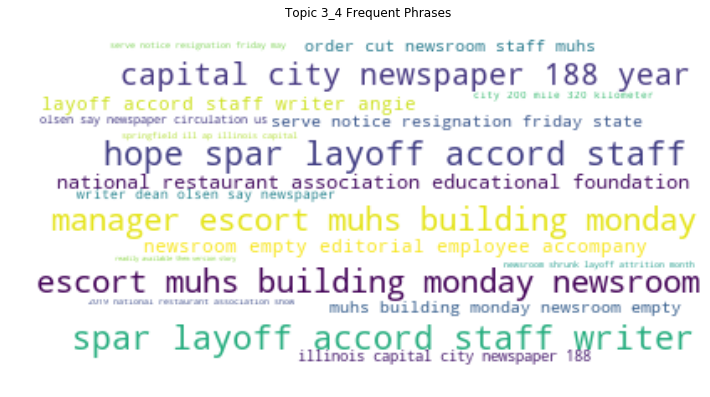


Representing 1 percent of the corpus


In [464]:
# Topic 3_4

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_3_4_text = [news_final[i] for i in topic_3_4_keys]
topic_3_4_text = " ".join([doc for doc in topic_3_4_text])
topic_3_4_text = topic_3_4_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_3_4_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_3_4_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_3_4_df.iterrows():
    if i[0] != 0:
        if fdist_3_4_df.iloc[i[0],1] == fdist_3_4_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_3_4_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_3_4_df = fdist_3_4_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_3_4_df['Phrase'] = fdist_3_4_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_3_4_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 3_4 Frequent Phrases\n")
plt.show()

topic_3_4_text = [news_final[i] for i in topic_3_4_keys]
percent = len(topic_3_4_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


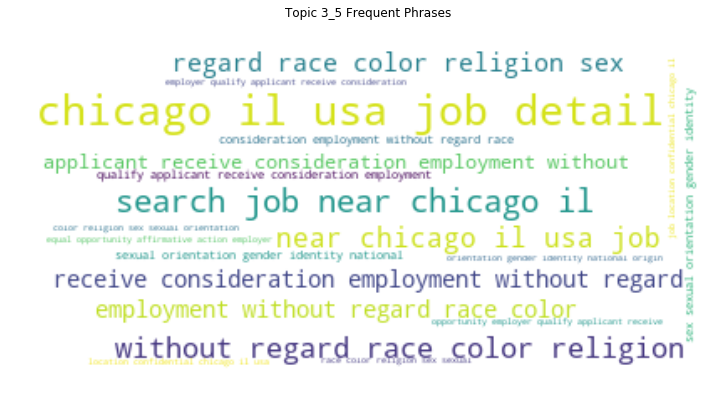


Representing 6 percent of the corpus


In [465]:
# Topic 3_5

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_3_5_text = [news_final[i] for i in topic_3_5_keys]
topic_3_5_text = " ".join([doc for doc in topic_3_5_text])
topic_3_5_text = topic_3_5_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_3_5_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_3_5_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_3_5_df.iterrows():
    if i[0] != 0:
        if fdist_3_5_df.iloc[i[0],1] == fdist_3_5_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_3_5_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_3_5_df = fdist_3_5_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_3_5_df['Phrase'] = fdist_3_5_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_3_5_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 3_5 Frequent Phrases\n")
plt.show()

topic_3_5_text = [news_final[i] for i in topic_3_5_keys]
percent = len(topic_3_5_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [180]:
# Topic 2-Specific LDA:

# Pulling out only articles related to topic 2:

topic_2_docs = [docs_split[i] for i in topic_2_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_2_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_2_docs]

# LDA:

lda2_topic2 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 

In [181]:
lda2_topic2_display = pyLDAvis.gensim.prepare(lda2_topic2, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda2_topic2_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 2 Sub Topics:

1. Baseball
2. College sports
3. Draft picks
4. Financial news, Illinois Tool Works?
5. Mix between First Mid-Illinois Bancshares, Inc. and the Bears

In [430]:
# Pulling out only articles related to topic 2:

topic_2_docs = [docs_split[i] for i in topic_2_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_2_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_2_docs]

# Get document topics with certainty of over 30 percent:

doc_topics_2 = dict(zip(topic_2_keys,[lda2_topic2.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in topic_2_docs]))

# Take the top topic only, discard topics below 30 percent:

top_topic = {}
for i in doc_topics_2:
    if len(doc_topics_2[i]) > 1:
        listy = [k[1] for k in doc_topics_2[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics_2[i][indexy]
    
    elif len(doc_topics_2[i]) == 1:
        top_topic[i] = doc_topics_2[i][0]
            
    else:
        pass
    
# Getting keys/indexes specific to each topic:

topic_2_1 = {}
topic_2_2 = {}
topic_2_3 = {}
topic_2_4 = {}
topic_2_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_2_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_2_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_2_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_2_4[key] = top_topic[key]
    else:
        topic_2_5[key] = top_topic[key]

topic_2_1_keys = list(topic_2_1.keys())
topic_2_2_keys = list(topic_2_2.keys())
topic_2_3_keys = list(topic_2_3.keys())
topic_2_4_keys = list(topic_2_4.keys())
topic_2_5_keys = list(topic_2_5.keys())

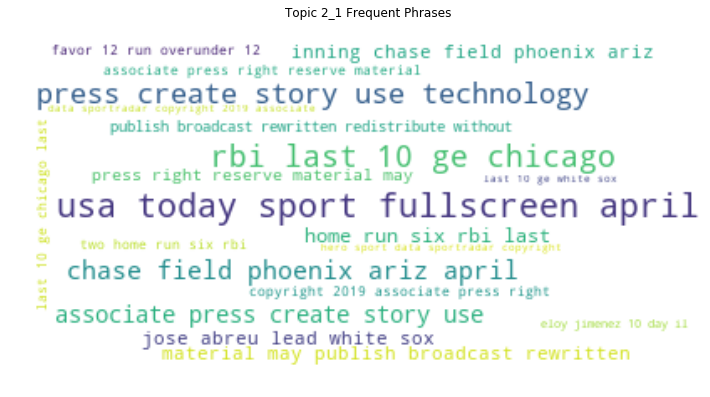


Representing 3 percent of the corpus


In [466]:
# Topic 2_1

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_2_1_text = [news_final[i] for i in topic_2_1_keys]
topic_2_1_text = " ".join([doc for doc in topic_2_1_text])
topic_2_1_text = topic_2_1_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_2_1_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_2_1_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_2_1_df.iterrows():
    if i[0] != 0:
        if fdist_2_1_df.iloc[i[0],1] == fdist_2_1_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_2_1_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_2_1_df = fdist_2_1_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_2_1_df['Phrase'] = fdist_2_1_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_2_1_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 2_1 Frequent Phrases\n")
plt.show()

topic_2_1_text = [news_final[i] for i in topic_2_1_keys]
percent = len(topic_2_1_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [1]:
# Topic 2_2

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_2_2_text = [news_final[i] for i in topic_2_2_keys]
topic_2_2_text = " ".join([doc for doc in topic_2_2_text])
topic_2_2_text = topic_2_2_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_2_2_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_2_2_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_2_2_df.iterrows():
    if i[0] != 0:
        if fdist_2_2_df.iloc[i[0],1] == fdist_2_2_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_2_2_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_2_2_df = fdist_2_2_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_2_2_df['Phrase'] = fdist_2_2_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_2_2_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 2_2 Frequent Phrases\n")
plt.show()

topic_2_2_text = [news_final[i] for i in topic_2_2_keys]
percent = len(topic_2_2_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


NameError: name 'topic_2_2_keys' is not defined

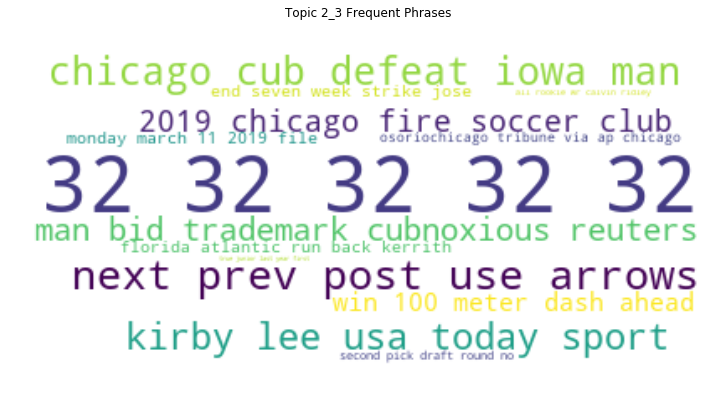


Representing 1 percent of the corpus


In [468]:
# Topic 2_3

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_2_3_text = [news_final[i] for i in topic_2_3_keys]
topic_2_3_text = " ".join([doc for doc in topic_2_3_text])
topic_2_3_text = topic_2_3_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_2_3_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_2_3_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_2_3_df.iterrows():
    if i[0] != 0:
        if fdist_2_3_df.iloc[i[0],1] == fdist_2_3_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_2_3_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_2_3_df = fdist_2_3_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_2_3_df['Phrase'] = fdist_2_3_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_2_3_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 2_3 Frequent Phrases\n")
plt.show()

topic_2_3_text = [news_final[i] for i in topic_2_3_keys]
percent = len(topic_2_3_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


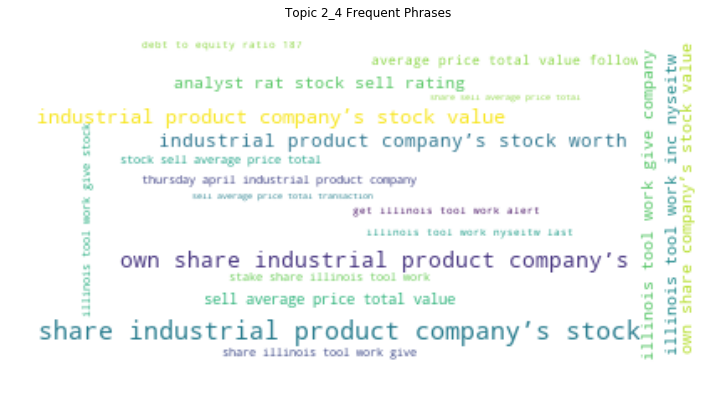


Representing 2 percent of the corpus


In [469]:
# Topic 2_4

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_2_4_text = [news_final[i] for i in topic_2_4_keys]
topic_2_4_text = " ".join([doc for doc in topic_2_4_text])
topic_2_4_text = topic_2_4_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_2_4_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_2_4_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_2_4_df.iterrows():
    if i[0] != 0:
        if fdist_2_4_df.iloc[i[0],1] == fdist_2_4_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_2_4_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_2_4_df = fdist_2_4_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_2_4_df['Phrase'] = fdist_2_4_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_2_4_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 2_4 Frequent Phrases\n")
plt.show()

topic_2_4_text = [news_final[i] for i in topic_2_4_keys]
percent = len(topic_2_4_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


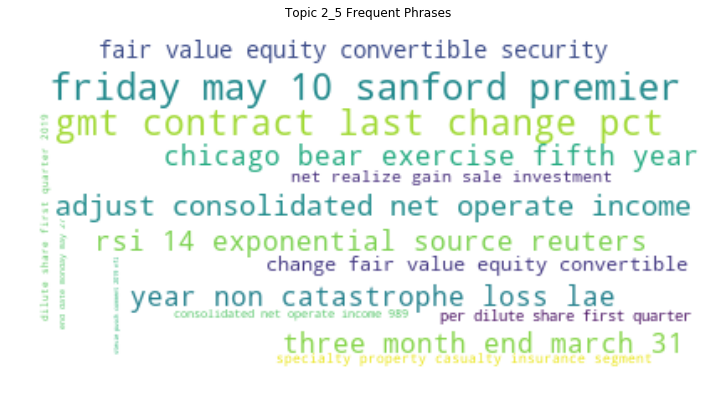


Representing 0 percent of the corpus


In [470]:
# Topic 2_5

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_2_5_text = [news_final[i] for i in topic_2_5_keys]
topic_2_5_text = " ".join([doc for doc in topic_2_5_text])
topic_2_5_text = topic_2_5_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_2_5_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_2_5_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_2_5_df.iterrows():
    if i[0] != 0:
        if fdist_2_5_df.iloc[i[0],1] == fdist_2_5_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_2_5_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_2_5_df = fdist_2_5_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_2_5_df['Phrase'] = fdist_2_5_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_2_5_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 2_5 Frequent Phrases\n")
plt.show()

topic_2_5_text = [news_final[i] for i in topic_2_5_keys]
percent = len(topic_2_5_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [182]:
# Topic 1-Specific LDA:


# Pulling out only articles related to topic 1:

topic_1_docs = [docs_split[i] for i in topic_1_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_1_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_1_docs]

# LDA:

lda1_topic1 = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50) 

In [183]:
lda1_topic1_display = pyLDAvis.gensim.prepare(lda1_topic1, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda1_topic1_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 1 Sub Topics

1. Waukegan Plant Explosion
2. Collection of commonly used words
3. Difficult to discern a particular topic
4. Difficult to discern a particular topic
5. Festivals-related

In [436]:
# Pulling out only articles related to topic 1:

topic_1_docs = [docs_split[i] for i in topic_1_keys]

# Creating the term dictionary of our corpus, where every unique term is assigned an index:

dictionary = corpora.Dictionary(topic_1_docs)

# Converting list of documents into document term matrix using dictionary prepared above:

doc_term_matrix = [dictionary.doc2bow(doc) for doc in topic_1_docs]

# Get document topics with certainty of over 30 percent:

doc_topics_1 = dict(zip(topic_1_keys,[lda1_topic1.get_document_topics(dictionary.doc2bow(doc), minimum_probability = .3) for doc in topic_1_docs]))

# Take the top topic only, discard topics below 30 percent:

top_topic = {}
for i in doc_topics_1:
    if len(doc_topics_1[i]) > 1:
        listy = [k[1] for k in doc_topics_1[i]]
        indexy = listy.index(max(listy))
        top_topic[i] = doc_topics_1[i][indexy]
    
    elif len(doc_topics_1[i]) == 1:
        top_topic[i] = doc_topics_1[i][0]
            
    else:
        pass
    
# Getting keys/indexes specific to each topic:

topic_1_1 = {}
topic_1_2 = {}
topic_1_3 = {}
topic_1_4 = {}
topic_1_5 = {}

for key in top_topic:
    if top_topic[key][0] == 0:
        topic_1_1[key] = top_topic[key]
    elif top_topic[key][0] == 1:
        topic_1_2[key] = top_topic[key]
    elif top_topic[key][0] == 2:
        topic_1_3[key] = top_topic[key]
    elif top_topic[key][0] == 3:
        topic_1_4[key] = top_topic[key]
    else:
        topic_1_5[key] = top_topic[key]

topic_1_1_keys = list(topic_1_1.keys())
topic_1_2_keys = list(topic_1_2.keys())
topic_1_3_keys = list(topic_1_3.keys())
topic_1_4_keys = list(topic_1_4.keys())
topic_1_5_keys = list(topic_1_5.keys())

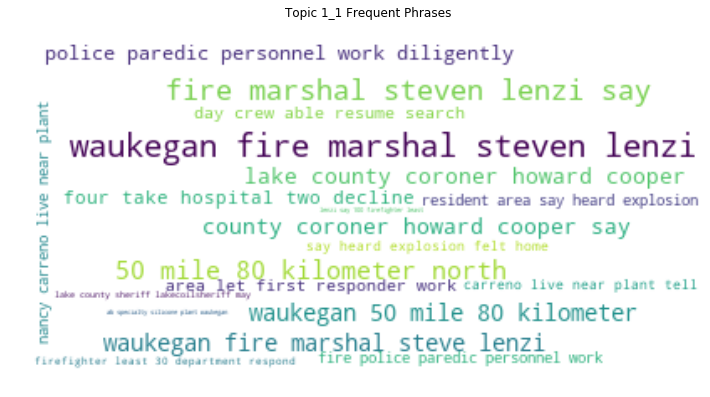


Representing 3 percent of the corpus


In [471]:
# Topic 1_1

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_1_1_text = [news_final[i] for i in topic_1_1_keys]
topic_1_1_text = " ".join([doc for doc in topic_1_1_text])
topic_1_1_text = topic_1_1_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_1_1_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_1_1_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_1_1_df.iterrows():
    if i[0] != 0:
        if fdist_1_1_df.iloc[i[0],1] == fdist_1_1_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_1_1_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_1_1_df = fdist_1_1_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_1_1_df['Phrase'] = fdist_1_1_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_1_1_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 1_1 Frequent Phrases\n")
plt.show()

topic_1_1_text = [news_final[i] for i in topic_1_1_keys]
percent = len(topic_1_1_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


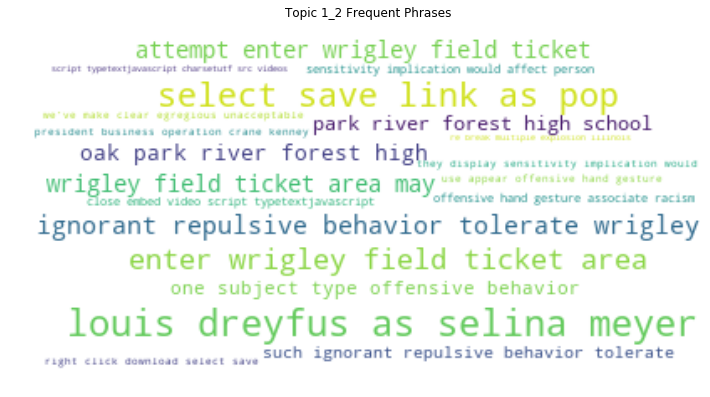


Representing 9 percent of the corpus


In [472]:
# Topic 1_2

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_1_2_text = [news_final[i] for i in topic_1_2_keys]
topic_1_2_text = " ".join([doc for doc in topic_1_2_text])
topic_1_2_text = topic_1_2_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_1_2_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_1_2_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_1_2_df.iterrows():
    if i[0] != 0:
        if fdist_1_2_df.iloc[i[0],1] == fdist_1_2_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_1_2_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_1_2_df = fdist_1_2_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_1_2_df['Phrase'] = fdist_1_2_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_1_2_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 1_2 Frequent Phrases\n")
plt.show()

topic_1_2_text = [news_final[i] for i in topic_1_2_keys]
percent = len(topic_1_2_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


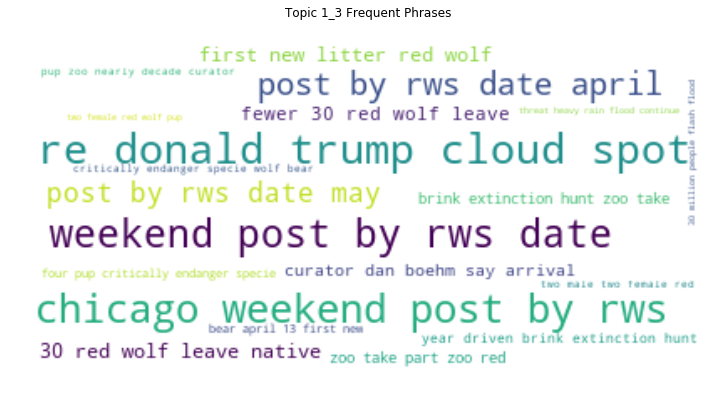


Representing 2 percent of the corpus


In [473]:
# Topic 1_3

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_1_3_text = [news_final[i] for i in topic_1_3_keys]
topic_1_3_text = " ".join([doc for doc in topic_1_3_text])
topic_1_3_text = topic_1_3_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_1_3_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_1_3_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_1_3_df.iterrows():
    if i[0] != 0:
        if fdist_1_3_df.iloc[i[0],1] == fdist_1_3_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_1_3_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_1_3_df = fdist_1_3_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_1_3_df['Phrase'] = fdist_1_3_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_1_3_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 1_3 Frequent Phrases\n")
plt.show()

topic_1_3_text = [news_final[i] for i in topic_1_3_keys]
percent = len(topic_1_3_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


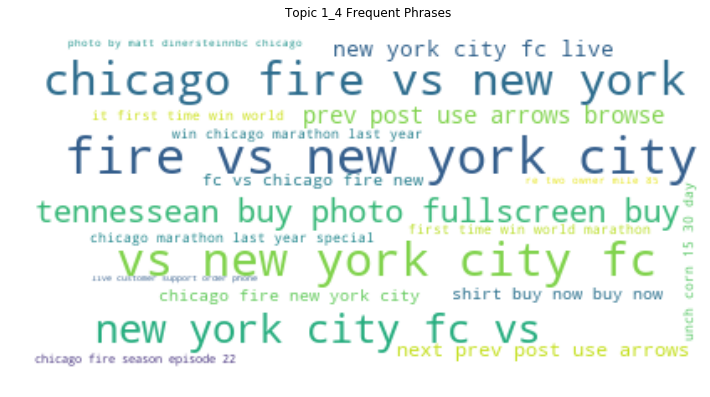


Representing 6 percent of the corpus


In [474]:
# Topic 1_4

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_1_4_text = [news_final[i] for i in topic_1_4_keys]
topic_1_4_text = " ".join([doc for doc in topic_1_4_text])
topic_1_4_text = topic_1_4_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_1_4_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_1_4_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_1_4_df.iterrows():
    if i[0] != 0:
        if fdist_1_4_df.iloc[i[0],1] == fdist_1_4_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_1_4_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_1_4_df = fdist_1_4_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_1_4_df['Phrase'] = fdist_1_4_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_1_4_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 1_4 Frequent Phrases\n")
plt.show()

topic_1_4_text = [news_final[i] for i in topic_1_4_keys]
percent = len(topic_1_4_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


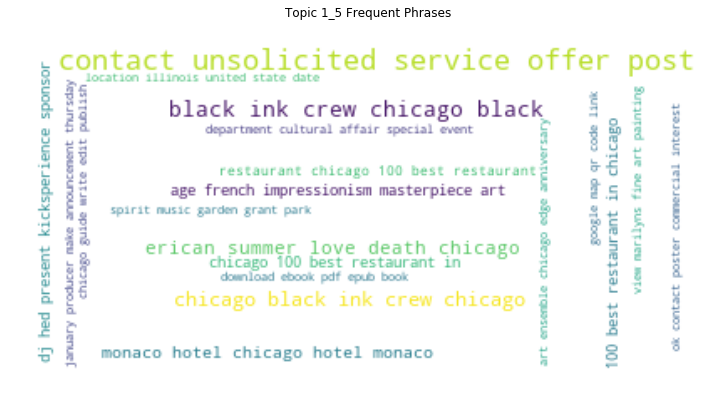


Representing 14 percent of the corpus


In [475]:
# Topic 1_5

# Pull out cleaned up articles related to the topic, create ngrams, create a frequency dataframe:

topic_1_5_text = [news_final[i] for i in topic_1_5_keys]
topic_1_5_text = " ".join([doc for doc in topic_1_5_text])
topic_1_5_text = topic_1_5_text.replace("\x92","").replace("april 29 2019","").replace("\x94","").replace("\x93","")
grams = nltk.ngrams(topic_1_5_text.split(), 5)
fdist = nltk.FreqDist(grams)
fdist_1_5_df = pd.DataFrame(fdist.most_common(),
                    columns=['Phrase', 'Frequency'])

# Remove redundant frequencies (often, but not always, a variation on the same ngram):

indexes_to_remove = []
for i in fdist_1_5_df.iterrows():
    if i[0] != 0:
        if fdist_1_5_df.iloc[i[0],1] == fdist_1_5_df.iloc[i[0]-1,1]:
            indexes_to_remove.append(i[0])
        else:
            pass
    else:
        pass
    
fdist_1_5_df.drop(indexes_to_remove, inplace=True)

# Keeping only the top twenty:

fdist_1_5_df = fdist_1_5_df.iloc[0:20] 

# Change the ngram from tuple to string:

def tuple_to_list(row):
    listy = " ".join(i for i in row)
    return listy

fdist_1_5_df['Phrase'] = fdist_1_5_df['Phrase'].apply(tuple_to_list)

# Generate word cloud:

d = {}
for a, x in fdist_1_5_df.values:
    d[a] = x
    
wordcloud = WordCloud(max_font_size=100, background_color="white", relative_scaling = .3, prefer_horizontal=.5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic 1_5 Frequent Phrases\n")
plt.show()

topic_1_5_text = [news_final[i] for i in topic_1_5_keys]
percent = len(topic_1_5_text)/len(news_final)*100
print("\nRepresenting %d percent of the corpus" % percent)


In [481]:
topics = ["topic_1.1", "topic_1.2", "topic_1.3", "topic_1.4", "topic_1.5", 
          "topic_2.1", "topic_2.2", "topic_2.3", "topic_2.4", "topic_2.5",
         "topic_3.1", "topic_3.2", "topic_3.3", "topic_3.4", "topic_3.5",
         "topic_4.1", "topic_4.2", "topic_4.3", "topic_4.4", "topic_4.5",
         "topic_5.1", "topic_5.2", "topic_5.3", "topic_5.4", "topic_5.5",]

topic_5_1 = len([news_final[i] for i in topic_5_1_keys])/len(news_final)*100
topic_5_2 = len([news_final[i] for i in topic_5_2_keys])/len(news_final)*100
topic_5_3 = len([news_final[i] for i in topic_5_3_keys])/len(news_final)*100
topic_5_4 = len([news_final[i] for i in topic_5_4_keys])/len(news_final)*100
topic_5_5 = len([news_final[i] for i in topic_5_5_keys])/len(news_final)*100
topic_4_1 = len([news_final[i] for i in topic_4_1_keys])/len(news_final)*100
topic_4_2 = len([news_final[i] for i in topic_4_2_keys])/len(news_final)*100
topic_4_3 = len([news_final[i] for i in topic_4_3_keys])/len(news_final)*100
topic_4_4 = len([news_final[i] for i in topic_4_4_keys])/len(news_final)*100
topic_4_5 = len([news_final[i] for i in topic_4_5_keys])/len(news_final)*100
topic_3_1 = len([news_final[i] for i in topic_3_1_keys])/len(news_final)*100
topic_3_2 = len([news_final[i] for i in topic_3_2_keys])/len(news_final)*100
topic_3_3 = len([news_final[i] for i in topic_3_3_keys])/len(news_final)*100
topic_3_4 = len([news_final[i] for i in topic_3_4_keys])/len(news_final)*100
topic_3_5 = len([news_final[i] for i in topic_3_5_keys])/len(news_final)*100
topic_2_1 = len([news_final[i] for i in topic_2_1_keys])/len(news_final)*100
topic_2_2 = len([news_final[i] for i in topic_2_2_keys])/len(news_final)*100
topic_2_3 = len([news_final[i] for i in topic_2_3_keys])/len(news_final)*100
topic_2_4 = len([news_final[i] for i in topic_2_4_keys])/len(news_final)*100
topic_2_5 = len([news_final[i] for i in topic_2_5_keys])/len(news_final)*100
topic_1_1 = len([news_final[i] for i in topic_1_1_keys])/len(news_final)*100
topic_1_2 = len([news_final[i] for i in topic_1_2_keys])/len(news_final)*100
topic_1_3 = len([news_final[i] for i in topic_1_3_keys])/len(news_final)*100
topic_1_4 = len([news_final[i] for i in topic_1_4_keys])/len(news_final)*100
topic_1_5 = len([news_final[i] for i in topic_1_5_keys])/len(news_final)*100

percentages = [topic_1_1, topic_1_2, topic_1_3, topic_1_4, topic_1_5,
              topic_2_1, topic_2_2, topic_2_3, topic_2_4, topic_2_5,
              topic_3_1, topic_3_2, topic_3_3, topic_3_4, topic_3_5,
              topic_4_1, topic_4_2, topic_4_3, topic_4_4, topic_4_5,
              topic_5_1, topic_5_2, topic_5_3, topic_5_4, topic_5_5]


Text(0, 0.5, 'Topic')

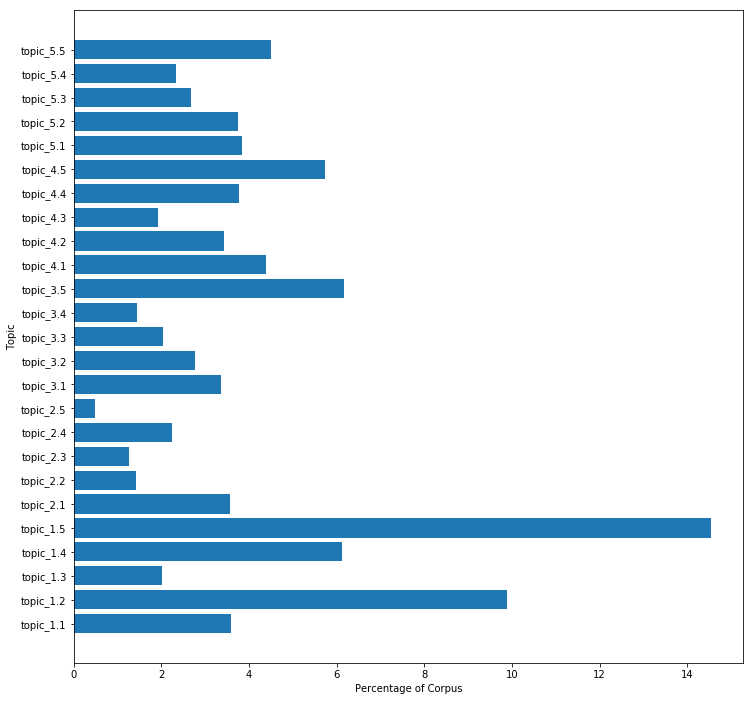

In [486]:
plt.figure(figsize=(12,12))
plt.barh(topics, percentages)
plt.xlabel("Percentage of Corpus")
plt.ylabel("Topic")



### The End